In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S1

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_path = "../../data/BacDrop"
data_gene = sc.read_h5ad(data_path + "/pseudomonas_data_processed.h5ad")


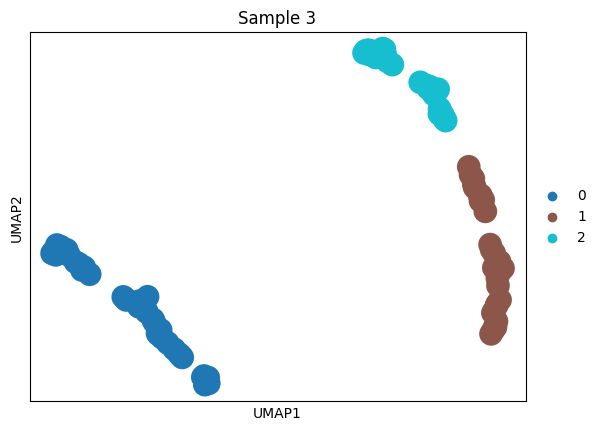

In [5]:
# sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


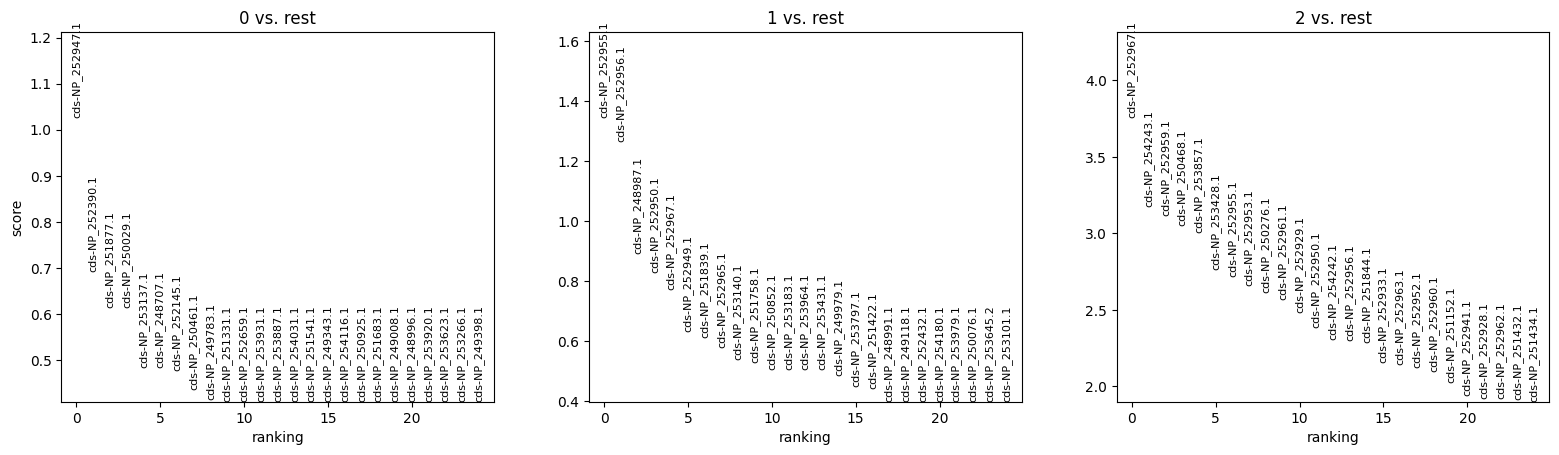

In [ ]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [7]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
gene 200
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 500
Both NB and ZINB not converged! Using NB without starting params
gene 600


## Find optimal correlation matrix scaling and generate synthetic null data

In [8]:
importlib.reload(cd)
try:
    xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
except:
    _, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=1234, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)
    xmin = 1
print(xmin)

Factor: 1 - Error: 0.5665250945183552
Factor: 2 - Error: 0.5665250945183552
Factor: 3.6180339999999998 - Error: 0.5665250945183552
1


In [9]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [10]:
importlib.reload(cd)
n, p = data_gene.X.shape
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, new_data_shape=(2*n, p),
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)


In [11]:
data_null_gen.var_names

Index(['cds-NP_064721.1', 'cds-NP_064722.1', 'cds-NP_064723.1',
       'cds-NP_064724.1', 'cds-NP_064728.1', 'cds-NP_248707.1',
       'cds-NP_248725.1', 'cds-NP_248735.1', 'cds-NP_248736.1',
       'cds-NP_248760.1',
       ...
       'cds-NP_254242.1', 'cds-NP_254243.1', 'cds-NP_254244.1',
       'cds-NP_254245.1', 'cds-NP_254246.1', 'cds-NP_254249.1',
       'cds-NP_254252.1', 'cds-NP_254255.1', 'cds-NP_254256.1',
       'cds-YP_003933614.1'],
      dtype='object', length=586)

In [12]:
data_null_gen.X.sum(axis=1)

array([17., 46., 23., 35., 20., 33., 33., 24., 31., 34., 52., 34., 27.,
       30., 33., 28., 39., 31., 32., 28., 24., 28., 35., 30., 26., 36.,
       44., 30., 34., 40., 38., 42., 36., 35., 36., 27., 42., 16., 35.,
       36., 38., 31., 34., 31., 33., 56., 27., 36., 32., 47., 36., 33.,
       44., 47., 30., 46., 37., 44., 37., 36., 28., 36., 47., 30., 38.,
       38., 24., 40., 27., 33., 33., 25., 44., 41., 30., 35., 29., 46.,
       43., 27., 44., 27., 32., 32., 54., 33., 33., 37., 34., 29., 36.,
       38., 41., 15., 40., 39., 41., 37., 52., 36., 29., 52., 28., 31.,
       41., 32., 23., 28., 31., 47., 42., 34., 28., 39., 48., 33., 24.,
       22., 29., 23., 21., 33., 31., 39., 35., 36., 35., 30., 32., 29.,
       35., 30., 24., 26., 31., 18., 33., 40., 37., 41., 39., 40., 30.,
       27., 38., 34., 28., 26., 47., 39., 38., 38., 43., 21., 35., 39.,
       49., 27., 34., 29., 36., 36., 27., 36., 34., 22., 27., 45., 37.,
       32., 33., 31., 32., 22., 34., 40., 37., 37., 32., 29., 34

In [13]:
# sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [14]:
data_null_gen.var

,var_counts,mean_counts
cds-NP_064721.1,0.032826,0.033981
cds-NP_064722.1,0.064568,0.058252
cds-NP_064723.1,0.095131,0.082524
cds-NP_064724.1,0.078542,0.063107
cds-NP_064728.1,0.050547,0.053398
...,...,...
cds-NP_254249.1,0.009614,0.009709
cds-NP_254252.1,0.028278,0.029126
cds-NP_254255.1,0.046187,0.048544
cds-NP_254256.1,0.089382,0.053398


In [15]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

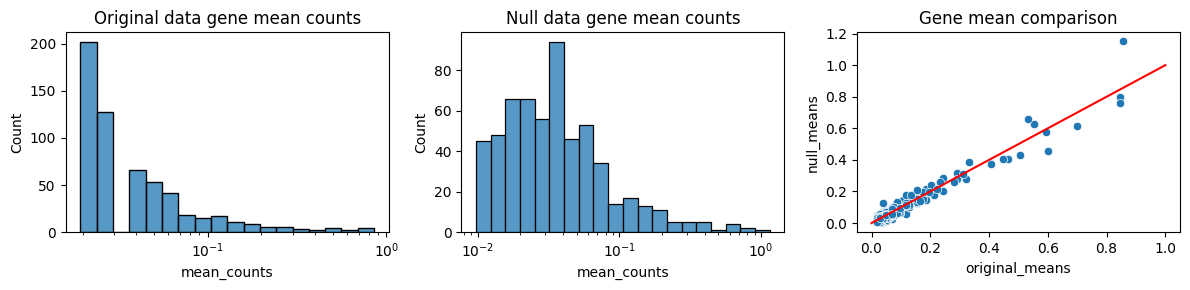

SignificanceResult(statistic=0.7958975584038182, pvalue=2.20370110162209e-129)


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

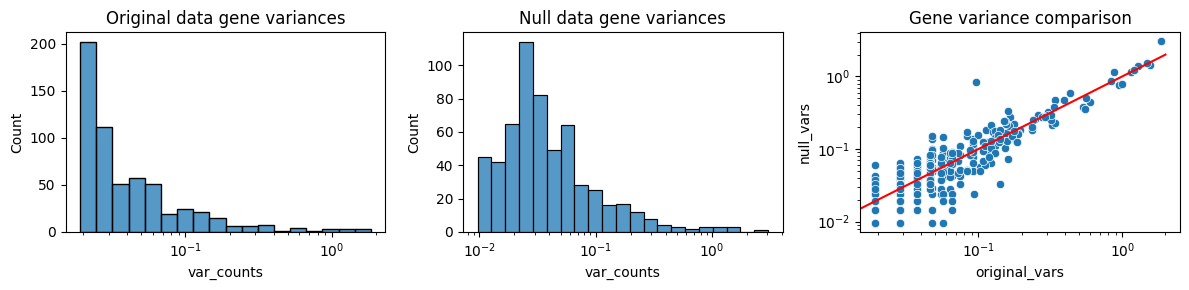

SignificanceResult(statistic=0.7784744753405423, pvalue=3.195028229357657e-120)
[[1.         0.94696206]
 [0.94696206 1.        ]]


In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

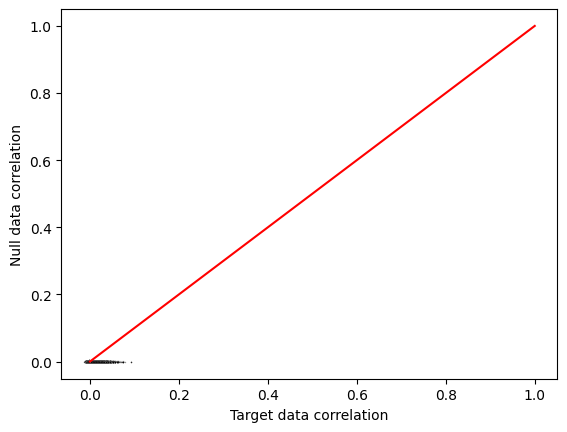

In [18]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [19]:
# sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [20]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform", seed=1234)
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


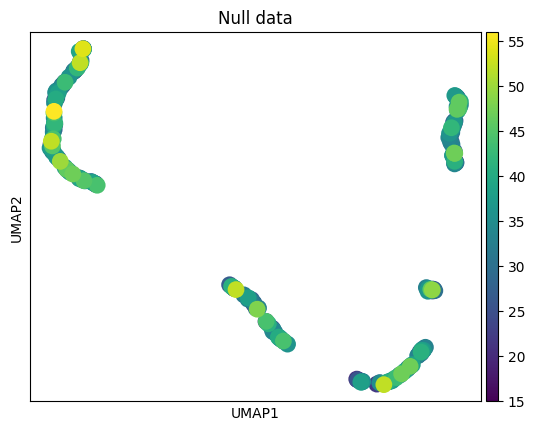

In [21]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [22]:
data_null_gen.write(data_path + "/null_data_pseudomonas.h5ad")

In [23]:
n_splits = 1
rng = np.random.default_rng(1234)
seeds = rng.choice(1000, n_splits)
null_pvals_dict = {}
min_pvals_null = []
c = 0
res_start = 0.01
res_step = 0.01

for s in seeds:
    res2 = res_start
    twoclust = False
    was_greater = False
    max_res_1_cluster = 0.01
    
    while twoclust is False:
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{c}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{c}"].unique())
        print(f"resolution: {res2}, clusters: {nclust}")

        if nclust == 2:
            twoclust = True
            break
        elif nclust < 2:
            if res2 > max_res_1_cluster:
                max_res_1_cluster = res2
            else: 
                res_step = res_step/2
            if was_greater:
                res2 += res_step
            else:
                res2 += 5*res_step
        else:
            was_greater = True
            min_res_2plus_clusters = res2
            res2 -= res_step
        res2 = np.round(res2, 15)

            
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{c}"] != "0"]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    null_pvals_dict[c] = null_pvals

    clusters = data_gene.obs["leiden_opt"].unique()
            
    min_pvals_null.append(np.min(null_pvals))
            
    print(f"split {c+1}/{n_splits} - Resolution {res2}")

    res_start = res2 - 5*res_step
    c += 1
    
best_split = np.where(min_pvals_null == np.max(min_pvals_null))[0][0]
print(f"Best split: No. {best_split} - seed: {seeds[best_split]} - minimal p-value: {min_pvals_null[best_split]}")

resolution: 0.01, clusters: 2
split 1/1 - Resolution 0.01
Best split: No. 0 - seed: 979 - minimal p-value: 0.06197497472306493


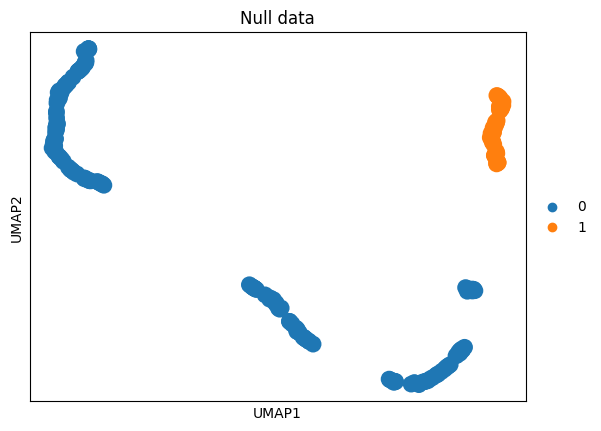

In [24]:
sc.pl.umap(data_null_gen, color=f"leiden_{best_split}", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [25]:
data_null_gen.obs["leiden_best"] = data_null_gen.obs[f"leiden_{best_split}"]

data_null_gen.write(data_path + "/null_data_pseudomonas.h5ad")

In [26]:
importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05
rng = np.random.default_rng(1234)

for c in clusters:
    
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    
    n_cells_0 = X_data_0.shape[0]
    n_cells_1 = X_data_1.shape[0]
    
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] != "0"]
    X_null_gen_0 = X_null_gen_0[rng.integers(X_null_gen_0.shape[0], size=n_cells_0),:]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_best"] == "0"]
    X_null_gen_1 = X_null_gen_1[rng.integers(X_null_gen_1.shape[0], size=n_cells_1),:]
    null_pvals = ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue
    
    pvals_data = ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue
    p_data = pd.DataFrame({"pval_data": pvals_data}, index=data_gene_nonzero.var.index)
    pval_null_gen = pd.DataFrame({"pval_null": null_pvals}, index=data_null_gen.var.index)
    
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 2 - DE genes: 48; Minimum q value: 0.023255813953488372
Cluster 0 - DE genes: 0; Minimum q value: 0.18181818181818182
Cluster 1 - DE genes: 0; Minimum q value: 1.0


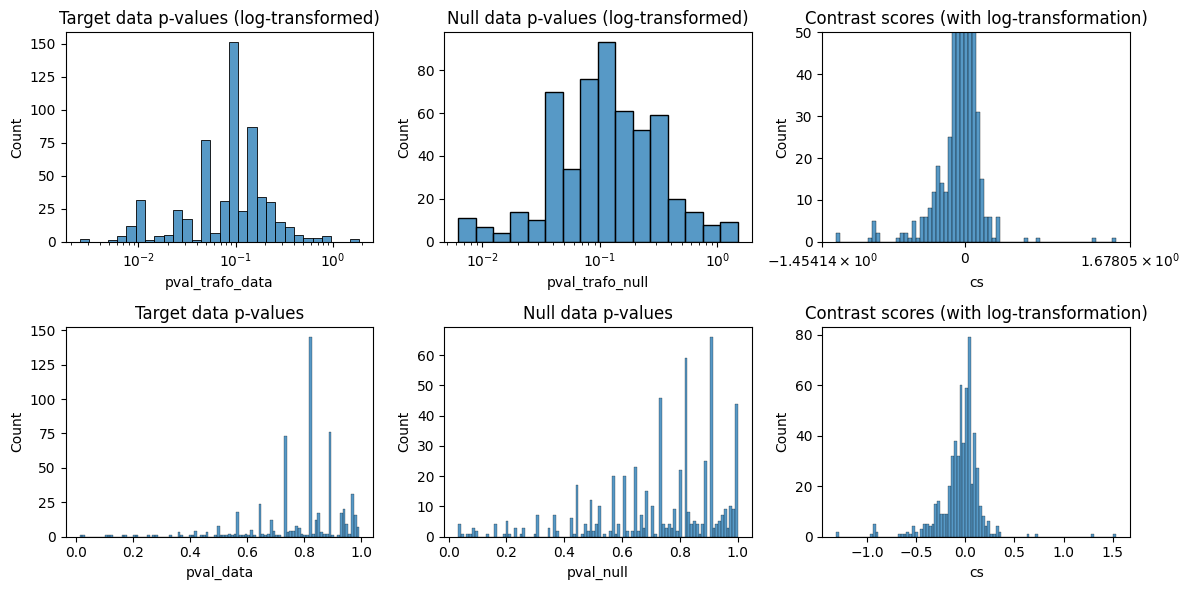

In [27]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_trafo_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_trafo_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (with log-transformation)")


plt.tight_layout()
plt.show()

In [28]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 2
0.023256     43
0.041667      5
0.054545      7
0.065574      6
0.096774      1
0.117647     23
0.122222      5
0.126316      5
0.134021      2
0.183673      1
0.188119      3
0.190476      4
0.205607      2
0.207207      4
0.232143      1
0.232759      4
0.235714     24
0.255319      1
0.260563      1
0.265734      1
0.267760     40
0.296875      9
0.307692      3
0.311224      1
0.323232      2
0.326633      1
0.330472     34
0.350427      1
0.363636      8
0.365854      4
0.368421      1
0.370968      1
0.371429     32
0.373665      1
0.395425     25
0.397394      1
0.400000      3
0.401929      1
0.402145     62
0.430481      1
0.453826      5
0.455497      3
0.458333      2
0.464103      6
0.464286      2
1.000000    194
Name: q, dtype: int64

cluster 0
0.181818     11
0.214286      3
0.235294      3
0.315789      2
0.391304      4
0.435897     16
0.450000      1
0.487805      1
0.500000      3
0.521739      2
0.553191      1
0.566038      6
0.568966      5
0.576271     

In [29]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
cds-NP_252967.1,0.000031,0.744817,4.511515,0.127951,4.383564,0.181818
cds-NP_252955.1,0.000173,0.215653,3.760716,0.666245,3.094470,0.181818
cds-NP_252950.1,0.003081,0.621832,2.511298,0.206327,2.304972,0.181818
cds-NP_253428.1,0.011189,0.965206,1.951210,0.015380,1.935831,0.181818
cds-NP_253857.1,0.029428,0.957184,1.531239,0.019005,1.512235,0.181818
...,...,...,...,...,...,...
cds-NP_253258.1,0.572944,0.101532,0.241887,0.993399,-0.751511,1.000000
cds-NP_253621.1,0.572944,0.093398,0.241887,1.029662,-0.787775,1.000000
cds-NP_252221.1,0.783202,0.101532,0.106126,0.993399,-0.887272,1.000000
cds-NP_252938.1,0.497894,0.053681,0.302863,1.270177,-0.967315,1.000000


In [30]:
data_gene_nonzero.uns["ClusterDE_results"] = pvals_log_gen

data_gene_nonzero.uns["ClusterDE_results"]['params'] = {'groupby': 'leiden_opt',
  'reference': 'rest',
  'use_raw': False,
  'layer': None,
}

In [31]:
data_gene_nonzero.write(data_path + "/filtered_data_maxpool_processed_cluster.h5ad")

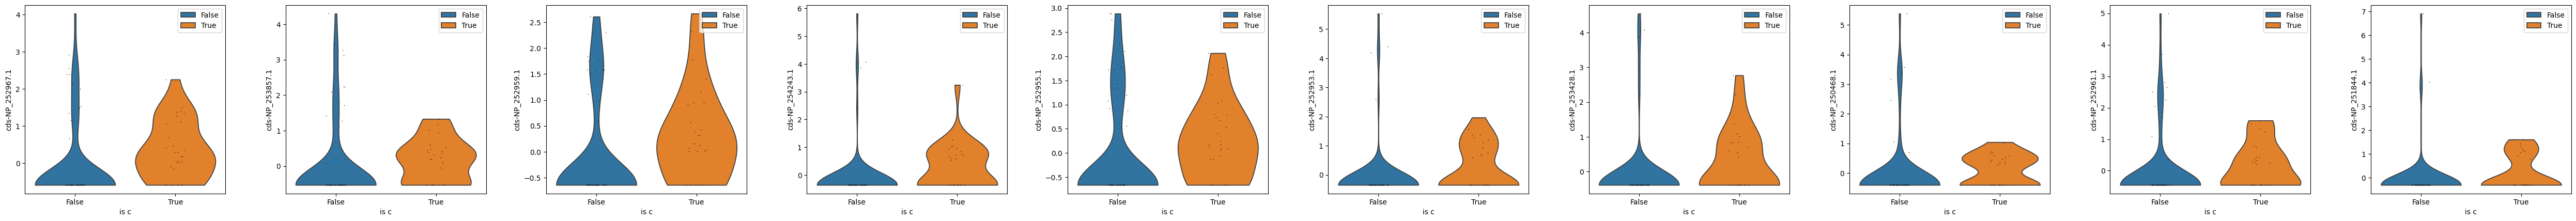

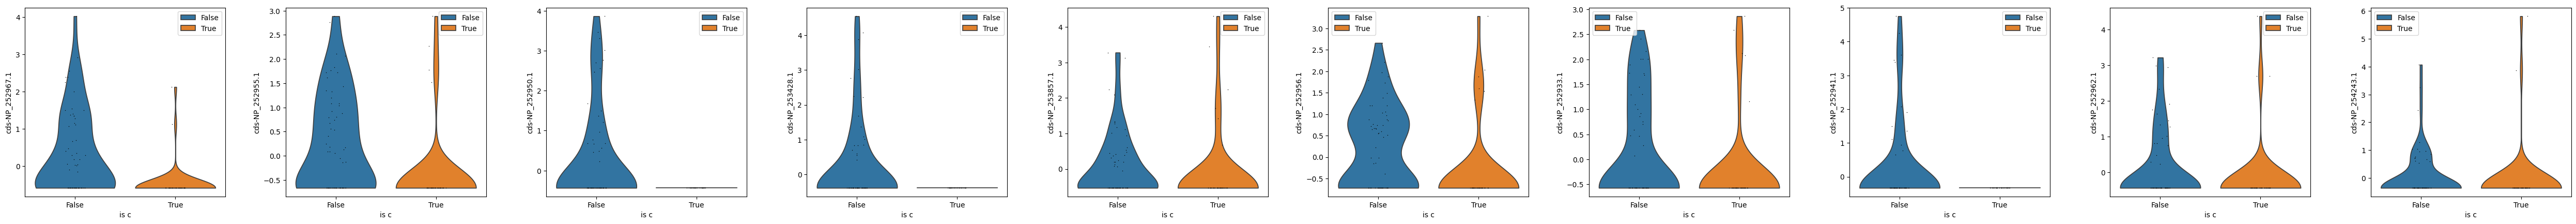

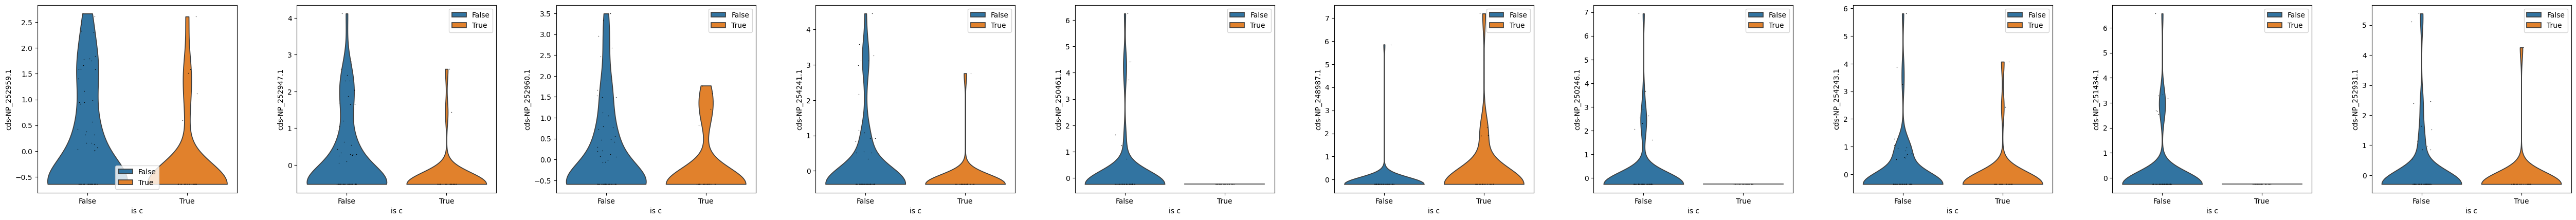

In [32]:
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:10,:].index.tolist()
    data_gene_nonzero.obs["is_c"] = pd.Categorical([x==c for x in data_gene_nonzero.obs["leiden_opt"]])
    with plt.rc_context({"figure.figsize": (5, 5)}):
        sc.pl.violin(data_gene_nonzero, keys=plot_genes, groupby="is_c", multi_panel=True)

In [33]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,product_accession,name,symbol,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
cds-NP_064721.1,4,0.038835,0.038100,96.116505,4.0,1.609438,4,0.037327,False,1.857411,...,NP_064721.1,chromosome replication initiator DnaA,dnaA,0.038835,0.037327,0.001508,poi,0.038835,inf,0.000148
cds-NP_064722.1,5,0.048544,0.047402,95.145631,5.0,1.791759,5,0.046187,False,2.081593,...,NP_064722.1,DNA polymerase III subunit beta,dnaN,0.048544,0.046187,0.002356,poi,0.048540,inf,0.000103
cds-NP_064723.1,9,0.097087,0.092659,91.262136,10.0,2.397895,9,0.107079,False,1.723821,...,NP_064723.1,DNA replication and repair protein RecF,recF,0.097087,0.107079,-0.009992,nb,0.097090,0.818744,0.000000
cds-NP_064724.1,7,0.077670,0.074801,93.203883,8.0,2.197225,7,0.091055,False,0.936126,...,NP_064724.1,DNA gyrase subunit B,gyrB,0.077670,0.091055,-0.013385,nb,0.077669,0.376754,0.000000
cds-NP_064728.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490733,...,NP_064728.1,glycine--tRNA ligase subunit beta,glyS,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cds-NP_254251.1,2,0.019417,0.019231,98.058252,2.0,1.098612,2,0.019040,False,1.325248,...,NP_254251.1,16S rRNA methyltransferase GidB,gidB,0.019417,0.019040,0.000377,poi,0.019420,inf,0.000611
cds-NP_254252.1,3,0.029126,0.028710,97.087379,3.0,1.386294,3,0.028278,False,1.490733,...,NP_254252.1,tRNA uridine 5-carboxymethylaminomethyl modifi...,gidA,0.029126,0.028278,0.000848,poi,0.029180,inf,0.002113
cds-NP_254255.1,6,0.058252,0.056619,94.174757,6.0,1.945910,6,0.054859,False,2.264633,...,NP_254255.1,inner membrane protein translocase subunit YidC,NaN,0.058252,0.054859,0.003393,poi,0.058253,inf,0.000108
cds-NP_254256.1,4,0.048544,0.047402,96.116505,5.0,1.791759,4,0.065605,False,0.271008,...,NP_254256.1,ribonuclease P,rnpA,0.048544,0.065605,-0.017061,nb,0.048540,0.102454,0.000000


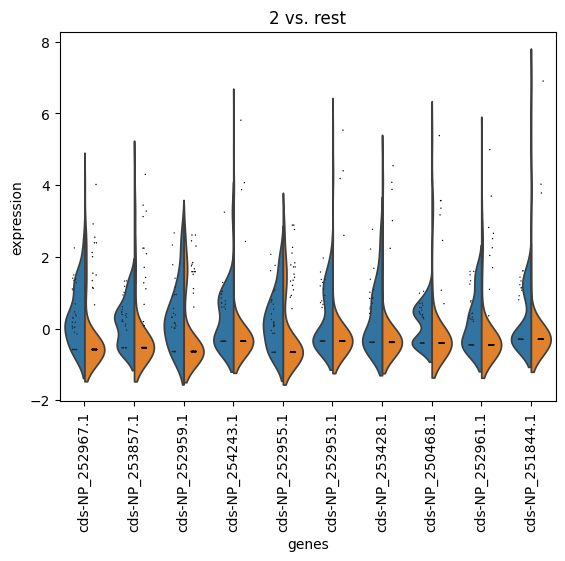

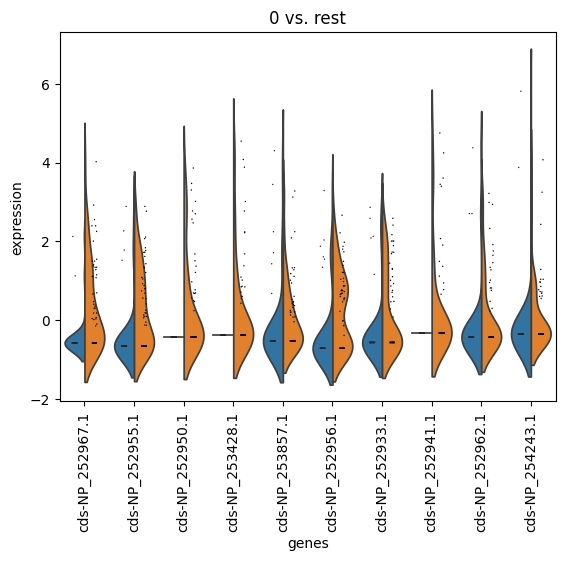

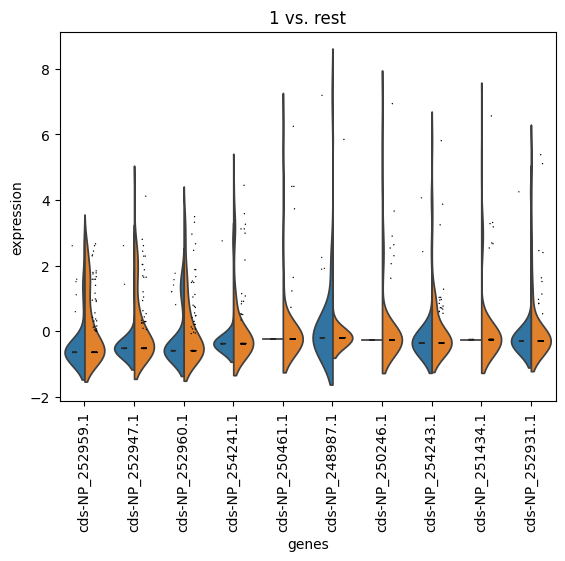

In [34]:
n_genes = 10
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    sc.pl.rank_genes_groups_violin(data_gene_nonzero, gene_names=plot_genes, key="ClusterDE_results", groups=c)

In [35]:
all_marker_genes = []
for c in clusters:
    plot_genes = data_gene_nonzero.uns["ClusterDE_results"][c].iloc[:n_genes,:].index.tolist()
    all_marker_genes += plot_genes
    print(f"Cluster {c}")
    print(data_gene.var.loc[plot_genes, ["locus_tag", "name", "symbol"]])

Cluster 2
                locus_tag                                       name symbol
cds-NP_252967.1    PA4277                       elongation factor Tu   tufB
cds-NP_253857.1    PA5170              arginine/ornithine antiporter   arcD
cds-NP_252959.1    PA4269  DNA-directed RNA polymerase subunit beta'   rpoC
cds-NP_254243.1    PA5556                 ATP synthase subunit alpha   atpA
cds-NP_252955.1    PA4265                       elongation factor Tu   tufA
cds-NP_252953.1    PA4263                   50S ribosomal protein L3   rplC
cds-NP_253428.1    PA4740               polynucleotide phosphorylase    pnp
cds-NP_250468.1    PA1777                     outer membrane porin F   oprF
cds-NP_252961.1    PA4271               50S ribosomal protein L7/L12   rplL
cds-NP_251844.1    PA3154                B-band O-antigen polymerase    wzy
Cluster 0
                locus_tag                                 name symbol
cds-NP_252967.1    PA4277                 elongation factor Tu   tufB
cds-

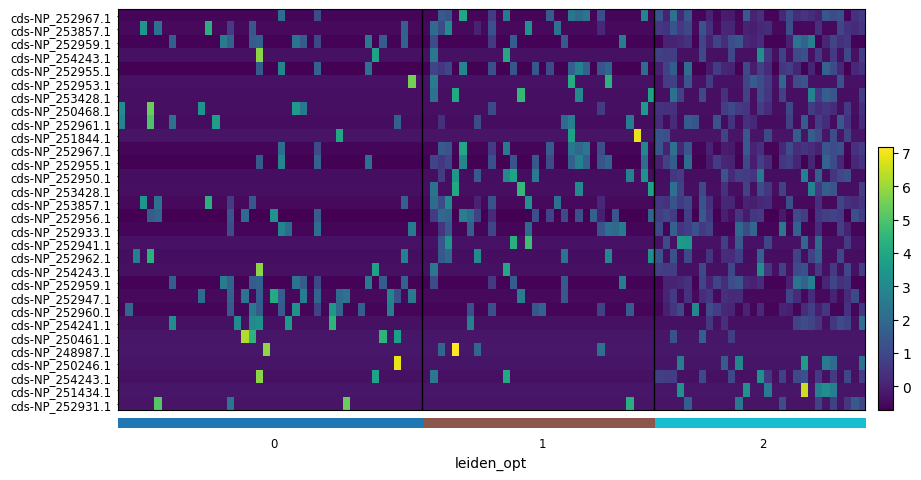

In [36]:
sc.pl.heatmap(data_gene_nonzero, all_marker_genes, groupby='leiden_opt', swap_axes=True)